In [257]:
import pandas as pd
import numpy as np
import os
from pandas_datareader import data as pdr
import datetime
import warnings
import fix_yahoo_finance as yf
import warnings
import matplotlib.pyplot as plt
import functools as ft
import pandas_talib as TA
import operator
import datetime
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
os.chdir("/Users/Hatim/Downloads")
warnings.filterwarnings("ignore")
yf.pdr_override()

# Data Retrieval 

In [2]:
#Downloading the Data for S&P500 Index directly from Yahoo!
start = "1995-01-01" 
end = "2017-12-17"
SPData = pdr.get_data_yahoo("^GSPC",start,end)

[*********************100%***********************]  1 of 1 downloaded

The SP500 may be highly influenced by other major financial major indexes across the world. So we can include them as features and need to get data for them. Indexes considered are FTSE100, NIKKEI225,DJIA, Frankfurt DAX, Paris CAC,Hong Kong Hang Seng, Australia AXJO and NASDAQ. Exchange rates may also influence SP500 so we can also take USD/CNY, USD/JPY,USD/EUR and USD/GBP. We also use VIX data since it incorporates information about the market volatility.

I chose to download the data from Yahoo! and fred so that anyone is able to run the whole code without worrying about the datsets.

In [3]:
#getting all the necessary data
FTSE = pdr.get_data_yahoo("^FTSE",start,end)
NIKKEI = pdr.get_data_yahoo("^N225",start,end)
DJI = pdr.get_data_yahoo("^DJI",start,end)
NASDAQ = pdr.get_data_yahoo("^IXIC",start,end)
CAC = pdr.get_data_yahoo("^FCHI",start,end)
HSI = pdr.get_data_yahoo("^HSI",start,end)
AXJO = pdr.get_data_yahoo("^AXJO",start,end)
SSE = pdr.get_data_yahoo("^SSEC",start,end)
VIX = pdr.get_data_yahoo("^VIX",start,end)
USDJPY = pdr.get_data_fred("DEXJPUS",start,end)
USDCNY = pdr.get_data_fred("DEXCHUS",start,end)
USDGBP = pdr.get_data_fred("DEXUSUK",start,end)
USDEUR = pdr.get_data_fred("DEXUSEU",start,end)
Gold = pdr.get_data_fred("GOLDPMGBD228NLBM",start,end)
#crude oil price - West Texas Intermediate
Oil = pdr.get_data_fred("DCOILWTICO",start,end)
Oil.columns = ['Price']
#It has null values, so dropping null values.
Oil.dropna(axis=0,how="all",inplace=True)

[*********************100%***********************]  1 of 1 downloaded

# Data Alignment and Merging


Renaming the columns so that we can identify different Close when we merge the data 


In [4]:
SPData.rename(columns = {'Close':'SP_Close'},inplace=True)
FTSE.rename(columns = {'Close':'FTSE_Close'},inplace=True)
NIKKEI.rename(columns = {'Close':'NIKKEI_Close'},inplace=True)
DJI.rename(columns = {'Close':'DJI_Close'},inplace=True)
NASDAQ.rename(columns = {'Close':'NASDAQ_Close'},inplace=True)
CAC.rename(columns = {'Close':'CAC_Close'},inplace=True)
HSI.rename(columns = {'Close':'HSI_Close'},inplace=True)
AXJO.rename(columns = {'Close':'AXJO_Close'},inplace=True)
SSE.rename(columns = {'Close':'SSE_Close'},inplace=True)
VIX.rename(columns = {'Close':'VIX_Close'},inplace=True)
USDJPY.columns = ["USDJPY_Close"]
USDCNY.columns = ["USDCNY_Close"]
USDGBP.columns = ["USDGBP_Close"]
USDEUR.columns = ["USDEUR_Close"]
Gold.columns = ["Gold_Price"]
Oil.rename(columns = {'Price':'Oil_Price'},inplace=True)

In [5]:
Tickers = ["SP","FTSE","NIKKEI","DJI","NASDAQ","CAC","HSI","AXJO","USDJPY","USDCNY","USDGBP","USDEUR","VIX"]
dfs = [SPData,FTSE,NIKKEI,DJI,NASDAQ,CAC,HSI,AXJO,SSE,VIX]

We drop the Adjusted Close column since it would be wise to work on the Close instead of Adjusted Close. Also,since we are working on indexes Adjusted Close is equal to the Close. Please refer to this link which explains it nicely

http://www.priceactionlab.com/Blog/2011/03/chaos-in-technical-analysis-and-backtesting-part-i-close-vs-adjusted-close/

In [6]:
for df in dfs:
    df.drop(axis=1,columns="Adj Close",inplace=True)

In [7]:
#List of data to be merged
Temp = [SPData,FTSE["FTSE_Close"],NIKKEI["NIKKEI_Close"],DJI["DJI_Close"],NASDAQ["NASDAQ_Close"],CAC["CAC_Close"],HSI["HSI_Close"],AXJO["AXJO_Close"],
USDJPY["USDJPY_Close"],USDCNY["USDCNY_Close"],USDGBP["USDGBP_Close"],USDEUR["USDEUR_Close"],Gold["Gold_Price"],Oil["Oil_Price"],VIX["VIX_Close"],SSE["SSE_Close"]]
MergingList = [Temp[i].to_frame() for i in range(1,len(Temp))]
MergingList.insert(0,SPData)

In [8]:
Data = ft.reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True),MergingList)

In [9]:
Data.dropna(inplace=True)

We have enough data points to do 2500 out of sample predictions

I will be working with 3 Target variables which will be described shortly as follows. I got this idea from the following paper:

Application of machine learning techniques for stock market prediction by Bin Weng, Auburn University, May 6, 2017

Target 1: Close(i+1) - Close(i)

Target 2: Open(i+1) - Open(i)

Target 3: if Return > 0.0015 -> +1
            else -1

In [132]:
DataTemp = Data.copy(deep=True)

# Feature Generation

In [133]:
#Function to create label 3
def target_label(x):
    if x>0.0015:
        return 1
    else:
        return -1

Technical indicators are used extensively in the industry and they speak quite well about the trend. People have successfully traded using technical indicators so I decided to use several technical indicators in my project.

In [134]:
def STOK(close, low, high, n): 
 STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
 return STOK

In [135]:
DataTemp["STOK"] = STOK(DataTemp["SP_Close"],DataTemp["Low"],DataTemp["High"],14)

In [136]:
def STOD(close, low, high, n):
 STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
 STOD = pd.rolling_mean(STOK, 3)
 return STOD

In [137]:
DataTemp["STOD"] = STOD(DataTemp["SP_Close"],DataTemp["Low"],DataTemp["High"],14)

In [138]:
def RSI(close, period):
    delta = close.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)

In [139]:
DataTemp["RSI"] = RSI(DataTemp["SP_Close"],14)

In [140]:
def CCI(close, high, low, n, constant): 
 TP = (high + low + close) / 3 
 CCI = pd.Series((TP - pd.rolling_mean(TP, n)) / (constant * pd.rolling_std(TP, n)), name = 'CCI_' + str(n)) 
 return CCI

In [141]:
DataTemp["CCI_20"] = CCI(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],20,0.015)
DataTemp["CCI_10"] = CCI(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],10,0.015)

In [142]:
def ACCDIST(Close, High, Low, Volume, n):  
    ad = (2 * Close - High - Low) / (High - Low) * Volume  
    M = ad.diff(n - 1)  
    N = ad.shift(n - 1)  
    ROC = M / N  
    AD = pd.Series(ROC, name = 'Acc/Dist_ROC_' + str(n))    
    return AD

In [143]:
DataTemp["ACCDIST"] = ACCDIST(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],DataTemp["Volume"],10)

In [144]:
def MOM(Close, n):  
    M = pd.Series(Close.diff(n), name = 'Momentum_' + str(n))    
    return M

In [145]:
DataTemp["MOM_3"] = MOM(DataTemp["SP_Close"],3)
DataTemp["MOM_5"] = MOM(DataTemp["SP_Close"],5)

In [146]:
def ROC(close, n):  
    M = close.diff(n - 1)  
    N = close.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

In [147]:
DataTemp["ROC_3"] = ROC(DataTemp["SP_Close"],3)
DataTemp["ROC_5"] = ROC(DataTemp["SP_Close"],5)
DataTemp["ROC_7"] = ROC(DataTemp["SP_Close"],7)

In [148]:
def MA(Close,n):
    MA = pd.Series(pd.rolling_mean(Close,n),name='MA_'+str(n))
    return MA

In [149]:
DataTemp["MA_10"] = MA(DataTemp["SP_Close"],10)
DataTemp["MA_5"] = MA(DataTemp["SP_Close"],10)

In [150]:
def ForceIndex(close, volume, n): 
 FI = pd.Series(close.diff(n) * volume, name = 'ForceIndex')  
 return FI

In [151]:
DataTemp["FI"] = ForceIndex(DataTemp["SP_Close"],DataTemp["Volume"],10)

In [152]:
def EMA(close, n):  
    EMA = pd.Series(pd.ewma(close, span = n, min_periods = n - 1), name = 'EMA_' + str(n))    
    return EMA

In [153]:
DataTemp["EMA_10"] = EMA(DataTemp["SP_Close"],10)
DataTemp["EMA_7"] = EMA(DataTemp["SP_Close"],7)

In [154]:
def EOM(High,Low,Volume,n):  
    EoM = (High.diff(1) + Low.diff(1)) * (High - Low) / (2 * Volume)  
    Eom_ma = pd.Series(pd.rolling_mean(EoM, n), name = 'EoM_' + str(n))  
    return Eom_ma

In [155]:
DataTemp["EOM"] = EOM(DataTemp["High"],DataTemp["Low"],DataTemp["Volume"],10)

In [156]:
def STDDEV(close, n):  
    stddev = pd.Series(pd.rolling_std(close, n), name = 'STD_' + str(n)) 
    return stddev

In [157]:
DataTemp["STDDEV_10"] = STDDEV(DataTemp["SP_Close"],10)
DataTemp["STDDEV_21"] = STDDEV(DataTemp["SP_Close"],21)

In [158]:
def Chaikin(close,high,low,volume):  
    ad = (2 * close - high - low) / (high - low) * volume 
    Chaikin = pd.Series(pd.ewma(ad, span = 3, min_periods = 2) - pd.ewma(ad, span = 10, min_periods = 9), name = 'Chaikin')   
    return Chaikin

In [159]:
DataTemp["Chaikin"] = Chaikin(DataTemp["SP_Close"],DataTemp["High"],DataTemp["Low"],DataTemp["Volume"])

In [160]:
def EMA(close, n):  
    EMA = pd.Series(pd.ewma(close, span = n, min_periods = n - 1), name = 'EMA_' + str(n))   
    return EMA

In [161]:
DataTemp["EMA_10"] = EMA(DataTemp["SP_Close"],10) 
DataTemp["EMA_7"] = EMA(DataTemp["SP_Close"],7) 

In [162]:
DataTemp["Target1"] = np.sign(DataTemp["SP_Close"].diff()).shift(-1)
DataTemp["Target2"] = np.sign(DataTemp["Open"].diff()).shift(-1)
DataTemp["Target3"] = DataTemp["SP_Close"].pct_change().apply(target_label).shift(-1)
DataTemp.ix[DataTemp.Target2==0, 'Target2'] = 1

Since we want to trade at the open of the market. We cannot use the features such as low,high, volume, etc.
but we can definitely use the returns of the other indices since they trade before US market and will affect US market

In [259]:
Features_label2 = ["HSI_Returns","AXJO_Returns","SSE_Returns"]

In [163]:
DataTemp["Open_Change"] = DataTemp["Open"].pct_change()
DataTemp["High_Change"] = DataTemp["High"].pct_change()
DataTemp["Volume_Change"] = DataTemp["Volume"].pct_change()
DataTemp["Low_Change"] = DataTemp["Low"].pct_change()

In [164]:
#Calculating Returns
ReturnsList = [i for i in DataTemp.columns if any(['_Close' in i,'_Price' in i])]
for i in ReturnsList:
    DataTemp[i.split("_")[0]+"_Returns"] = DataTemp[i].pct_change()
Drop = [i for i in DataTemp.columns if any(["_Price" in i,"_Close" in i])]
DataTemp.drop(Drop,axis=1,inplace=True)

In [165]:
DataTemp.dropna(inplace=True)
ColsList = list(DataTemp.columns)
ColsList.pop(ColsList.index("Target1"))
ColsList.pop(ColsList.index("Target2"))
ColsList.pop(ColsList.index("Target3"))
DataTemp = DataTemp[ColsList+["Target1"]+["Target2"]+["Target3"]]

In [166]:
DataTemp.dropna(inplace=True)

In [167]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

In [45]:
parameters = {"n_estimators":[100,500,1000],"criterion":["entropy","gini"],"max_features":["sqrt","log2",10,20],
              "max_depth":[10,15,20,None],"min_samples_leaf":[1,5,10,15,20]}

In [46]:
RC = RandomForestClassifier(oob_score=True,n_jobs=-1,random_state=123)

Using first 250 points for parameter tuning to just get a rough estimate of the parameters. 
A better approach would be to do parameter tuning every time we train the model. But GridSearchCV is a costly process
I tried using the parameters obtained by using first 250 points and got pretty good results.

In [193]:
gscv = GridSearchCV(RC,parameters,scoring="roc_auc",n_jobs=-1,cv=10)
gscv.fit(DataTemp[DataTemp.columns[:-1]][0:250],DataTemp[DataTemp.columns[-1]][0:250])

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 10, 20], 'max_depth': [10, 15, 20, None], 'min_samples_leaf': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [194]:
gscv.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [62]:
DataTemp.columns

Index(['Open', 'High', 'Low', 'Volume', 'STOK', 'STOD', 'RSI', 'CCI_20',
       'CCI_10', 'ACCDIST', 'MOM_3', 'MOM_5', 'ROC_3', 'ROC_5', 'ROC_7',
       'MA_10', 'MA_5', 'FI', 'EMA_10', 'EMA_7', 'EOM', 'STDDEV_10',
       'STDDEV_21', 'Chaikin', 'Open_Change', 'High_Change', 'Volume_Change',
       'Low_Change', 'SP_Returns', 'FTSE_Returns', 'NIKKEI_Returns',
       'DJI_Returns', 'NASDAQ_Returns', 'CAC_Returns', 'HSI_Returns',
       'AXJO_Returns', 'USDJPY_Returns', 'USDCNY_Returns', 'USDGBP_Returns',
       'USDEUR_Returns', 'Gold_Returns', 'Oil_Returns', 'VIX_Returns',
       'SSE_Returns', 'Target1', 'Target2', 'Target3'],
      dtype='object')

In [169]:
#Let's consider a Naive classifier where we predict all 1's and we will consider this classifier as our benchmark
#Lets see the f1 score and accuracy for this classifier

#Only the features (predictors) data
Features = DataTemp[DataTemp.columns[:-3]]
#Label or target data
Label1 = DataTemp[DataTemp.columns[-3]]
Label2 = DataTemp[DataTemp.columns[-2]]
Label3 = DataTemp[DataTemp.columns[-1]]
from sklearn.metrics import f1_score
#A function is created so that you pass the test set and it gives you the accuracy, f1 score and roc_auc_score by just predicting 
#all +1 on the test set.
def benchmark_stats(Test):
    #Calculating F1 score
    print ("F1 score for predicting all +1 on the test dataset: {:.4f}".format(
        f1_score(Test, [1]*len(Test), pos_label=1, average='binary')))

    #Calculating Accuracy score
    from sklearn.metrics import accuracy_score
    print ("Accuracy score for predicting all +1 on the test dataset: {:.4f}".format(
        accuracy_score(Test, [1]*len(Test))))
    
    #Calculating roc_auc score
    print("AUC score for predicting all +1 on the test dataset: {:.4f}".format(roc_auc_score(Test,[1]*len(Test))))
    
#We will be using the above function to compare the accuracy,f1 score and AUC score of our model

In [82]:
#Setting up some helper functions that may help to train, predict and evaluate our model.

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    clf.fit(X_train, y_train)
    print ("Model Trained!!!!")

def predict_labels_f1(clf, features, target):
    
    y_pred = clf.predict(features)
    return f1_score(target, y_pred, pos_label=1)

def predict_labels_accuracy(clf, features, target):
    
    y_pred = clf.predict(features)
    return accuracy_score(target, y_pred)   

def predict_labels_auc(clf,features,target):
    
    y_pred = clf.predict(features)
    return roc_auc_score(target,y_pred)

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer'''
    
    #Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    #Train the classifier
    train_classifier(clf, X_train, y_train)
    
    #Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels_f1(clf, X_train, y_train)))
    print ("Accuracy score for training set: {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
    print("AUC score for training set: {:.4f}.".format(predict_labels_auc(clf,X_train,y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels_f1(clf, X_test, y_test)))
    print ("Accuracy score for test set: {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))
    print("AUC score for the test set: {:.4f}.".format(predict_labels_auc(clf,X_test,y_test)))

In [196]:
# Import  three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression

DT = DecisionTreeClassifier(random_state=42)
GNB = GaussianNB()
svc = SVC(random_state=42)
RF = RandomForestClassifier(n_estimators=3000,criterion="gini",max_depth=25,max_features="log2",min_samples_leaf=5,random_state=42)
Logistic = LogisticRegression()

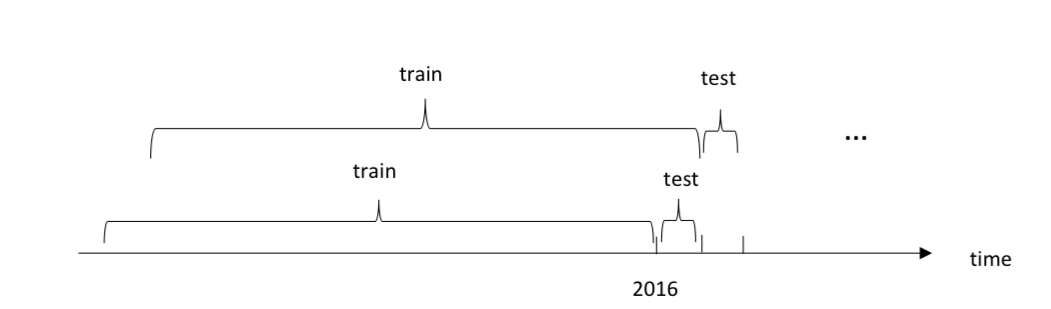

In [84]:
#working with Label1
for clf in [DT, GNB, svc,RF,Logistic]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for i in range(0,3525,100):
        if(len(Features[i+1000:i+1100]==100)):
            train_predict(clf, Features[i:i+1000], Label1[i:i+1000], Features[i+1000:i+1100], Label1[i+1000:i+1100])
            print('#'*40)
            print("BENCHMARK STATS - NAIVE CLASSIFIER")
            benchmark_stats(Label1[i+1000:i+1100])
            print('#'*40)
            print('-'*50)
        else:
            break     
        


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.4762.
Accuracy score for test set: 0.4500.
AUC score for the test set: 0.4536.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7342
Accuracy score for predicting all +1 on the test dataset: 0.5800
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.4571.
Accuracy score for test set: 0.4300.
AUC score for the test set: 0.4293.
#######

Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5812.
Accuracy score for test set: 0.5100.
AUC score for the test set: 0.4996.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7013
Accuracy score for predicting all +1 on the test dataset: 0.5400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5593.
Accuracy score for test set: 0.4800.
AUC score for the test set: 0.4631.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

F1 score for test set: 0.5766.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5385.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6395
Accuracy score for predicting all +1 on the test dataset: 0.4700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.5979.
Accuracy score for training set: 0.5440.
AUC score for training set: 0.5395.
F1 score for test set: 0.5149.
Accuracy score for test set: 0.5100.
AUC score for the test set: 0.5503.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy score for predicting all +1 on the test dataset: 0.6400
AUC score for predicting all +1 on the test datas

########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7578
Accuracy score for predicting all +1 on the test dataset: 0.6100
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.7168.
Accuracy score for training set: 0.5820.
AUC score for training set: 0.5270.
F1 score for test set: 0.7421.
Accuracy score for test set: 0.5900.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7421
Accuracy score for predicting all +1 on the test dataset: 0.5900
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
T

--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7261.
Accuracy score for test set: 0.5700.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7261
Accuracy score for predicting all +1 on the test dataset: 0.5700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.6928.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5000.
#####################

Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7421.
Accuracy score for test set: 0.5900.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7421
Accuracy score for predicting all +1 on the test dataset: 0.5900
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7578.
Accuracy score for test set: 0.6100.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset

Model Trained!!!!
F1 score for training set: 0.9981.
Accuracy score for training set: 0.9980.
AUC score for training set: 0.9978.
F1 score for test set: 0.7013.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.4737.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7261
Accuracy score for predicting all +1 on the test dataset: 0.5700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.9991.
Accuracy score for training set: 0.9990.
AUC score for training set: 0.9989.
F1 score for test set: 0.6379.
Accuracy score for test set: 0.5800.
AUC score for the test set: 0.5725.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

Model Trained!!!!
F1 score for training set: 0.9982.
Accuracy score for training set: 0.9980.
AUC score for training set: 0.9977.
F1 score for test set: 0.5253.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5496.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7421
Accuracy score for predicting all +1 on the test dataset: 0.5900
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.9991.
Accuracy score for training set: 0.9990.
AUC score for training set: 0.9988.
F1 score for test set: 0.7403.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.5057.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

Accuracy score for test set: 0.4200.
AUC score for the test set: 0.3856.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7261
Accuracy score for predicting all +1 on the test dataset: 0.5700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6861.
Accuracy score for training set: 0.5480.
AUC score for training set: 0.5119.
F1 score for test set: 0.6573.
Accuracy score for test set: 0.5100.
AUC score for the test set: 0.4859.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6928
Accuracy score for predicting all +1 on the test dataset: 0.5300
AUC score for predicting all +1 on the test dataset: 0.5000
############

Accuracy score for test set: 0.4800.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6486
Accuracy score for predicting all +1 on the test dataset: 0.4800
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.7277.
Accuracy score for training set: 0.5720.
AUC score for training set: 0.5000.
F1 score for test set: 0.6395.
Accuracy score for test set: 0.4700.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6395
Accuracy score for predicting all +1 on the test dataset: 0.4700
AUC score for predicting all +1 on the test dataset: 0.5000
############

In [197]:
#working with Label2
for clf in [DT, GNB, svc,RF,Logistic]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for i in range(0,3525,100):
        if(len(Features[i+1000:i+1100]==100)):
            train_predict(clf, DataTemp[Features_label2][i:i+1000], Label2[i:i+1000], DataTemp[Features_label2][i+1000:i+1100], Label2[i+1000:i+1100])
            print('#'*40)
            print("BENCHMARK STATS - NAIVE CLASSIFIER")
            benchmark_stats(Label2[i+1000:i+1100])
            print('#'*40)
            print('-'*50)
        else:
            break    


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5664.
Accuracy score for test set: 0.5100.
AUC score for the test set: 0.5020.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7097
Accuracy score for predicting all +1 on the test dataset: 0.5500
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.4854.
Accuracy score for test set: 0.4700.
AUC score for the test set: 0.4732.
#######

Accuracy score for predicting all +1 on the test dataset: 0.6000
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5636.
Accuracy score for test set: 0.5200.
AUC score for the test set: 0.5154.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7179
Accuracy score for predicting all +1 on the test dataset: 0.5600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000

F1 score for training set: 0.6628.
Accuracy score for training set: 0.5940.
AUC score for training set: 0.5826.
F1 score for test set: 0.6341.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5300.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7179
Accuracy score for predicting all +1 on the test dataset: 0.5600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6597.
Accuracy score for training set: 0.5790.
AUC score for training set: 0.5628.
F1 score for test set: 0.5983.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5197.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7013
Ac

Accuracy score for predicting all +1 on the test dataset: 0.6600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.7000.
Accuracy score for training set: 0.6100.
AUC score for training set: 0.5821.
F1 score for test set: 0.7183.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.5234.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy score for predicting all +1 on the test dataset: 0.6400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6956.
Accuracy score for tra

AUC score for training set: 0.5000.
F1 score for test set: 0.6928.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6928
Accuracy score for predicting all +1 on the test dataset: 0.5300
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6937.
Accuracy score for training set: 0.5310.
AUC score for training set: 0.5000.
F1 score for test set: 0.7730.
Accuracy score for test set: 0.6300.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7730
Accuracy score for predicting all +1 on the test dataset: 0.6300
AUC score for predic

Model Trained!!!!
F1 score for training set: 0.7253.
Accuracy score for training set: 0.5690.
AUC score for training set: 0.5000.
F1 score for test set: 0.7805.
Accuracy score for test set: 0.6400.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy score for predicting all +1 on the test dataset: 0.6400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------

RandomForestClassifier: 

Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.8733.
Accuracy score for training set: 0.8720.
AUC score for training set: 0.8720.
F1 score for test set: 0.5437.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5323.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 s

Model Trained!!!!
F1 score for training set: 0.8839.
Accuracy score for training set: 0.8710.
AUC score for training set: 0.8675.
F1 score for test set: 0.6774.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.5766.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7730
Accuracy score for predicting all +1 on the test dataset: 0.6300
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.8901.
Accuracy score for training set: 0.8760.
AUC score for training set: 0.8713.
F1 score for test set: 0.6441.
Accuracy score for test set: 0.5800.
AUC score for the test set: 0.5929.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

Model Trained!!!!
F1 score for training set: 0.8952.
Accuracy score for training set: 0.8740.
AUC score for training set: 0.8626.
F1 score for test set: 0.7273.
Accuracy score for test set: 0.6400.
AUC score for the test set: 0.5972.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy score for predicting all +1 on the test dataset: 0.6400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------

LogisticRegression: 

Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6033.
Accuracy score for training set: 0.5660.
AUC score for training set: 0.5658.
F1 score for test set: 0.6612.
Accuracy score for test set: 0.5900.
AUC score for the test set: 0.5747.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for

AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6868.
Accuracy score for training set: 0.5440.
AUC score for training set: 0.5266.
F1 score for test set: 0.7853.
Accuracy score for test set: 0.6500.
AUC score for the test set: 0.5139.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy score for predicting all +1 on the test dataset: 0.6400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6984.
Accuracy score for training set: 0.5440.
AUC score for training set: 0.

In [86]:
#working with Label3
for clf in [DT, GNB, svc,RF,Logistic]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for i in range(0,3525,100):
        if(len(Features[i+1000:i+1100]==100)):
            train_predict(clf, Features[i:i+1000], Label3[i:i+1000], Features[i+1000:i+1100], Label3[i+1000:i+1100])
            print('#'*40)
            print("BENCHMARK STATS - NAIVE CLASSIFIER")
            benchmark_stats(Label3[i+1000:i+1100])
            print('#'*40)
            print('-'*50)
        else:
            break    


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.4270.
Accuracy score for test set: 0.4900.
AUC score for the test set: 0.4838.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6111
Accuracy score for predicting all +1 on the test dataset: 0.4400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.4783.
Accuracy score for test set: 0.5200.
AUC score for the test set: 0.5169.
#######

Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5417.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5644.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6928
Accuracy score for predicting all +1 on the test dataset: 0.5300
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.2857.
Accuracy score for test set: 0.5000.
AUC score for the test set: 0.4526.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5314.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6301
Accuracy score for predicting all +1 on the test dataset: 0.4600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.2496.
Accuracy score for training set: 0.5670.
AUC score for training set: 0.5244.
F1 score for test set: 0.2623.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5221.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6301
Accuracy score for predicting all +1 on the test dataset: 0.4600
AUC score for predicting all +1 on the test dataset: 0.5000
####################

F1 score for predicting all +1 on the test dataset: 0.6301
Accuracy score for predicting all +1 on the test dataset: 0.4600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.3980.
Accuracy score for training set: 0.5280.
AUC score for training set: 0.5213.
F1 score for test set: 0.4267.
Accuracy score for test set: 0.5700.
AUC score for the test set: 0.5505.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6207
Accuracy score for predicting all +1 on the test dataset: 0.4500
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GaussianNB using a training set size of 1000. . .
Model Trained!!!

Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5900.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.5816
Accuracy score for predicting all +1 on the test dataset: 0.4100
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5200.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6486
Accuracy score for predicting all +1 on the 

Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6207
Accuracy score for predicting all +1 on the test dataset: 0.4500
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5700.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6014
Accuracy score for predicting all +1 on the 

Model Trained!!!!
F1 score for training set: 0.9967.
Accuracy score for training set: 0.9970.
AUC score for training set: 0.9969.
F1 score for test set: 0.4889.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5395.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.5816
Accuracy score for predicting all +1 on the test dataset: 0.4100
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.9956.
Accuracy score for training set: 0.9960.
AUC score for training set: 0.9956.
F1 score for test set: 0.4884.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5553.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

Model Trained!!!!
F1 score for training set: 0.9990.
Accuracy score for training set: 0.9990.
AUC score for training set: 0.9990.
F1 score for test set: 0.2222.
Accuracy score for test set: 0.5100.
AUC score for the test set: 0.4778.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6207
Accuracy score for predicting all +1 on the test dataset: 0.4500
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a RandomForestClassifier using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.5263.
Accuracy score for test set: 0.6400.
AUC score for the test set: 0.6185.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 

AUC score for the test set: 0.5375.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6928
Accuracy score for predicting all +1 on the test dataset: 0.5300
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a LogisticRegression using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.4690.
Accuracy score for training set: 0.5720.
AUC score for training set: 0.5601.
F1 score for test set: 0.4390.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5481.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6842
Accuracy score for predicting all +1 on the test dataset: 0.5200
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------

The accuracy for predicting the open of the market is quite good. Seems that the algorithms are able to capture the pattern for the open quite well.

It can be seen that Decision trees, GNB and SVC perform slightly better than the naive classifier which predicts all +1.Hence we haven't gained any advantage. So we will have to tune the parameters of the classifiers to achieve better results. Random forest performs quite well beating the naive classifier most of the time. We get respectable results for label 2

Random forests on the other hand (although not all the time, but most of the time) perform much better than the Naive classifier. At times achieving accuracy of 62%. So indicating that ML could be used in certain period to have significant gains.

We will pick individual classifiers and do the parameter tuning using gridsearchcv for all of them.

In [88]:
#Decision tree paramter tuning for label 1

parameters = {'max_depth': [1,2,3,4,5,6,7,8,9],'criterion':('gini','entropy'),'splitter':('best','random')}
DT = DecisionTreeClassifier(random_state=42)
gscv = GridSearchCV(DT, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+1000:i+1100]==100)):
        train_predict(gscv, Features[i:i+1000], Label1[i:i+1000], Features[i+1000:i+1100], Label1[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label1[i+1000:i+1100])
        print('#'*40)
        print('-'*50)
    else:
        break  

Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6386.
Accuracy score for training set: 0.6220.
AUC score for training set: 0.6221.
F1 score for test set: 0.5000.
Accuracy score for test set: 0.4600.
AUC score for the test set: 0.4589.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7342
Accuracy score for predicting all +1 on the test dataset: 0.5800
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6720.
Accuracy score for training set: 0.5080.
AUC score for training set: 0.5040.
F1 score for test set: 0.7097.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STA

Model Trained!!!!
F1 score for training set: 0.7155.
Accuracy score for training set: 0.5570.
AUC score for training set: 0.5000.
F1 score for test set: 0.7013.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7013
Accuracy score for predicting all +1 on the test dataset: 0.5400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.7197.
Accuracy score for training set: 0.5740.
AUC score for training set: 0.5159.
F1 score for test set: 0.7368.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.5304.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the tes

In [199]:
#Decision tree paramter tuning for label 2
parameters = {'max_depth': [1,2,3,4,5,6,7,8,9],'criterion':('gini','entropy'),'splitter':('best','random')}
DT = DecisionTreeClassifier(random_state=42)
gscv = GridSearchCV(DT, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+2000:i+2100]==100)):
        train_predict(gscv, DataTemp[Features_label2][i:i+1000], Label2[i:i+1000], DataTemp[Features_label2][i+1000:i+1100], Label2[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label2[i+1000:i+1100])
        print('#'*40)
        print('-'*50)
    else:
        break  

Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6963.
Accuracy score for training set: 0.6990.
AUC score for training set: 0.6990.
F1 score for test set: 0.5714.
Accuracy score for test set: 0.5200.
AUC score for the test set: 0.5131.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7097
Accuracy score for predicting all +1 on the test dataset: 0.5500
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.5142.
Accuracy score for training set: 0.5900.
AUC score for training set: 0.5913.
F1 score for test set: 0.5532.
Accuracy score for test set: 0.5800.
AUC score for the test set: 0.5958.
########################################
BENCHMARK STA

Model Trained!!!!
F1 score for training set: 0.6480.
Accuracy score for training set: 0.5860.
AUC score for training set: 0.5760.
F1 score for test set: 0.6000.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.6022.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6395
Accuracy score for predicting all +1 on the test dataset: 0.4700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6619.
Accuracy score for training set: 0.6180.
AUC score for training set: 0.6118.
F1 score for test set: 0.7179.
Accuracy score for test set: 0.6700.
AUC score for the test set: 0.6591.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the tes

Again it can be seen that the predictive power for open is really good.

In [171]:
#Decision tree paramter tuning for label 3
parameters = {'max_depth': [1,2,3,4,5,6,7,8,9],'criterion':('gini','entropy'),'splitter':('best','random')}
DT = DecisionTreeClassifier(random_state=42)
gscv = GridSearchCV(DT, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+2000:i+2100]==100)):
        train_predict(gscv, Features[i:i+1000], Label3[i:i+1000], Features[i+1000:i+1100], Label3[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label3[i+1000:i+1100])
        print('#'*40)
        print('-'*50)
    else:
        break  

Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.0000.
Accuracy score for training set: 0.5480.
AUC score for training set: 0.5000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6111
Accuracy score for predicting all +1 on the test dataset: 0.4400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.2478.
Accuracy score for training set: 0.5690.
AUC score for training set: 0.5297.
F1 score for test set: 0.3582.
Accuracy score for test set: 0.5700.
AUC score for the test set: 0.5471.
########################################
BENCHMARK STA

Model Trained!!!!
F1 score for training set: 0.5646.
Accuracy score for training set: 0.5820.
AUC score for training set: 0.5816.
F1 score for test set: 0.4330.
Accuracy score for test set: 0.4500.
AUC score for the test set: 0.4498.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6395
Accuracy score for predicting all +1 on the test dataset: 0.4700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a GridSearchCV using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 0.6157.
Accuracy score for training set: 0.5830.
AUC score for training set: 0.5879.
F1 score for test set: 0.5849.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5584.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the tes

It can be seen that the model is more adaptive and dynamic in nature. The accuracy scores have improved drastically and are almost equal and greater than the naive classifier accuracy

In [200]:
#Tuning SVC with train size of 1000 and test size of 100. Label 1
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}
svc = SVC(random_state=3)
gscv = GridSearchCV(svc, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+1000:i+1100]==100)):
        train_predict(svc, Features[i:i+1000], Label1[i:i+1000], Features[i+1000:i+1100], Label1[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label1[i+2000:i+2100])
        print('#'*40)
        print('-'*50)
    else:
        break  

Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.4200.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7500
Accuracy score for predicting all +1 on the test dataset: 0.6000
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7097.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIF

Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7013.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6928
Accuracy score for predicting all +1 on the test dataset: 0.5300
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7342.
Accuracy score for test set: 0.5800.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7342
Accuracy score for predicting all +1 on the 

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [173]:
#Tuning SVC with train size of 1000 and test size of 100. Label 2
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}
svc = SVC(random_state=3)
gscv = GridSearchCV(svc, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+1000:i+1100]==100)):
        train_predict(svc, Features[i:i+1000], Label2[i:i+1000], Features[i+1000:i+1100], Label2[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label2[i+2000:i+2100])
        print('#'*40)
        print('-'*50)
    else:
        break 

Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7097.
Accuracy score for test set: 0.5500.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7261
Accuracy score for predicting all +1 on the test dataset: 0.5700
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7179.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIF

F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.6395.
Accuracy score for test set: 0.4700.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7952
Accuracy score for predicting all +1 on the test dataset: 0.6600
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.7179.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7805
Accuracy 

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Although the above code didn't run because for some time period the classifier is predicting only one class. But whatever results we have in hand it can be seen after tuning the parameters for label2 (Open), we could achieve accuracy of 64%

In [174]:
#Tuning SVC with train size of 1000 and test size of 100. Label 3
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}
svc = SVC(random_state=3)
gscv = GridSearchCV(svc, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+1000:i+1100]==100)):
        train_predict(svc, Features[i:i+1000], Label3[i:i+1000], Features[i+1000:i+1100], Label3[i+1000:i+1100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label3[i+2000:i+2100])
        print('#'*40)
        print('-'*50)
    else:
        break 

Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5600.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6842
Accuracy score for predicting all +1 on the test dataset: 0.5200
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIF

AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.5300.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6111
Accuracy score for predicting all +1 on the test dataset: 0.4400
AUC score for predicting all +1 on the test dataset: 0.5000
########################################
--------------------------------------------------
Training a SVC using a training set size of 1000. . .
Model Trained!!!!
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
F1 score for test set: 0.0000.
Accuracy score for test set: 0.4700.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.6014
Accuracy score for predicting all +1 on the test dataset: 0.4300
AUC score for predic

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [595]:
#Tuning SVC with train size of 2000 and test size of 100
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}
svc = SVC(random_state=3)
gscv = GridSearchCV(svc, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+2000:i+2100]==100)):
        train_predict(svc, Features[i:i+2000], Label[i:i+2000], Features[i+2000:i+2100], Label[i+2000:i+2100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label[i+2000:i+2100])
        print('#'*40)
        print('-'*50)
    else:
        break  

Training a SVC using a training set size of 2000. . .
Model Trained!!!!
Made predictions in 0.2135 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
Made predictions in 0.0129 seconds.
F1 score for test set: 0.7500.
Accuracy score for test set: 0.6000.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7500
Accuracy score for predicting all +1 on the test dataset: 0.6000
########################################
--------------------------------------------------
Training a SVC using a training set size of 2000. . .
Model Trained!!!!
Made predictions in 0.2289 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
Made predictions in 0.0103 seconds.
F1 score for test set: 0.7261.
Accuracy score for test set: 0.5700.
AUC score for the test s

Model Trained!!!!
Made predictions in 0.1999 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
Made predictions in 0.0115 seconds.
F1 score for test set: 0.7013.
Accuracy score for test set: 0.5400.
AUC score for the test set: 0.5000.
########################################
BENCHMARK STATS - NAIVE CLASSIFIER
F1 score for predicting all +1 on the test dataset: 0.7013
Accuracy score for predicting all +1 on the test dataset: 0.5400
########################################
--------------------------------------------------
Training a SVC using a training set size of 2000. . .
Model Trained!!!!
Made predictions in 0.2233 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
AUC score for training set: 1.0000.
Made predictions in 0.0104 seconds.
F1 score for test set: 0.7342.
Accuracy score for test set: 0.5800.
AUC score for the test set: 0.5000.
########################################
B

In [ ]:
#Random forest tuning
parameters = {"criterion":["entropy","gini"],"max_features":["sqrt","log2",10,20],
              "max_depth":[10,15,20,None],"min_samples_leaf":[1,5,10,15,20]}
RF = RandomForestClassifier(n_estimators = 1000,oob_score=True,n_jobs=-1,random_state=42)
gscv = GridSearchCV(RF, parameters,cv=10,n_jobs=-1)
for i in range(0,3525,100):
    if(len(Features[i+2000:i+2100]==100)):
        train_predict(gscv, Features[i:i+2000], Label1[i:i+2000], Features[i+2000:i+2100], Label1[i+2000:i+2100])
        print('#'*40)
        print("BENCHMARK STATS - NAIVE CLASSIFIER")
        benchmark_stats(Label1[i+2000:i+2100])
        print('#'*40)
        print('-'*50)
    else:
        break  

**I strongly believe and also research supports that tuning Random forest parameters will give significant results. But grisearch with RandomForest takes a lot of time. I tried to run it and it kept running for more than 2 hours. However, I have included the code for the same above.**

We see a pattern of decreasing accuracy indicating that more and more people are trying to use Machine Learning for trading and hence it is unable to find pattern.

In [192]:
Features_label2 = ["HSI_Returns","AXJO_Returns","SSE_Returns"]

# Kalman filtering

Kalman filtering is a good technique to extract the true trend. We re-write the index as a local level model.

                                                        yt=αt+ϵt
                                                        αt=αt−1+ηt−1
 
where  ϵ and  η are white noise.

Kalman filtering progresses through time and filters the state out of the index time series.


The Kalman Filter is a unsupervised algorithm for tracking a single object in a continuous state space. Given a sequence of noisy measurements, the Kalman Filter is able to recover the “true state” of the underling object being tracked. Common uses for the Kalman Filter include radar and sonar tracking and state estimation in robotics.

The advantages of Kalman Filter are:

1. No need to provide labeled training data

2. Ability to handle noisy observations

In [188]:
from pykalman import KalmanFilter
import seaborn as sns

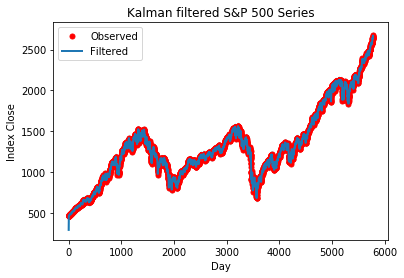

In [65]:
sp = SPData[['SP_Close']]
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1])
measurements = sp.values.flatten()
kf = kf.em(measurements, n_iter=3)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
plt.plot((sp.values), 'ro', markersize=5, label='Observed')
plt.plot((filtered_state_means), linewidth = 2, label = 'Filtered')
plt.fill_between(range(len(filtered_state_means)), 
                 filtered_state_means.flatten()-filtered_state_covariances.flatten(), 
                 filtered_state_means.flatten()+filtered_state_covariances.flatten(), alpha=0.3, color='cyan')
plt.title('Kalman filtered S&P 500 Series')
plt.xlabel('Day')
plt.ylabel('Index Close')
plt.legend()
plt.show()

Kalman filter performed really well because KF takes into consideration all the past information available.

Plot of Kalman filtered time series at the tail of the S&P 500.

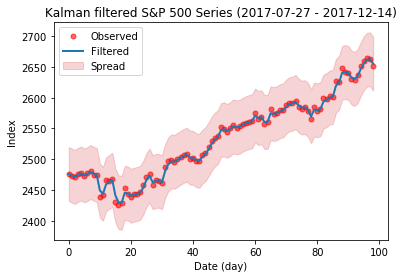

In [66]:
plt.plot((sp.values)[-100:-1], 'ro', alpha = 0.6, markersize=5, label='Observed')
plt.plot((filtered_state_means)[-100:-1], linewidth = 2, label='Filtered')
plt.fill_between(range(99), 
                 (filtered_state_means.flatten()-filtered_state_covariances.flatten())[-100:-1], 
                 (filtered_state_means.flatten()+filtered_state_covariances.flatten())[-100:-1], 
                 alpha=0.2, color=sns.color_palette()[3], label='Spread')
plt.title('Kalman filtered S&P 500 Series (2017-07-27 - 2017-12-14)')
plt.xlabel('Date (day)')
plt.ylabel('Index')
plt.legend()
plt.show()

In [67]:
observed_kf = sp.values.flatten()
observed_kf= observed_kf[1:] > observed_kf[:-1]

# daily trend of the filtered result
fil_kf = filtered_state_means.flatten()[1:] > filtered_state_means.flatten()[:-1]

# Get the accuracy
kf_match = (observed_kf == fil_kf)
np.mean(kf_match)

0.88548693997578276

We achieved predicting power of 88%. Thats pretty commendable.

Lets try Kalman filtering on the open data

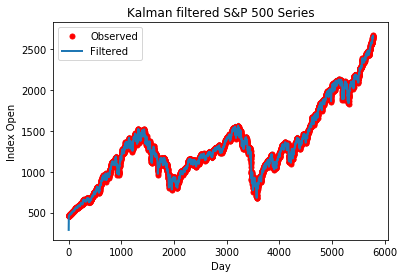

In [201]:
sp = SPData[['Open']]
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1])
measurements = sp.values.flatten()
kf = kf.em(measurements, n_iter=3)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
plt.plot((sp.values), 'ro', markersize=5, label='Observed')
plt.plot((filtered_state_means), linewidth = 2, label = 'Filtered')
plt.fill_between(range(len(filtered_state_means)), 
                 filtered_state_means.flatten()-filtered_state_covariances.flatten(), 
                 filtered_state_means.flatten()+filtered_state_covariances.flatten(), alpha=0.3, color='cyan')
plt.title('Kalman filtered S&P 500 Series')
plt.xlabel('Day')
plt.ylabel('Index Open')
plt.legend()
plt.show()

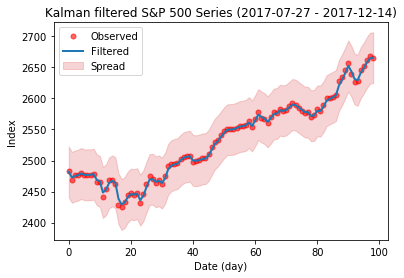

In [202]:
plt.plot((sp.values)[-100:-1], 'ro', alpha = 0.6, markersize=5, label='Observed')
plt.plot((filtered_state_means)[-100:-1], linewidth = 2, label='Filtered')
plt.fill_between(range(99), 
                 (filtered_state_means.flatten()-filtered_state_covariances.flatten())[-100:-1], 
                 (filtered_state_means.flatten()+filtered_state_covariances.flatten())[-100:-1], 
                 alpha=0.2, color=sns.color_palette()[3], label='Spread')
plt.title('Kalman filtered S&P 500 Series (2017-07-27 - 2017-12-14)')
plt.xlabel('Date (day)')
plt.ylabel('Index')
plt.legend()
plt.show()

In [203]:
observed_kf = sp.values.flatten()
observed_kf= observed_kf[1:] > observed_kf[:-1]

# daily trend of the filtered result
fil_kf = filtered_state_means.flatten()[1:] > filtered_state_means.flatten()[:-1]

# Get the accuracy
kf_match = (observed_kf == fil_kf)
np.mean(kf_match)

0.89396298218301329

In [204]:
#It can be observed here also that Kalman filter gives better results for Open data

In [208]:
#creating helper functions to use them for classification
from sklearn.ensemble import AdaBoostClassifier
def LinearSVM(X_train, y_train, X_test, y_test, parameters):
    clf=LinearSVC(loss="hinge",C=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, y_train, X_test, y_test, parameters):
    clf = RandomForestClassifier(n_estimators=parameters[0],n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

from sklearn.linear_model import LogisticRegression
def LogRegress(X_train, y_train, X_test, y_test, parameters):
    clf = LogisticRegression(C=parameters[0])
    clf.fit(X_train,y_train)
    accuracy = clf.score(X_test,y_test)
    return clf, accuracy

from sklearn import neighbors
def KNN(X_train, y_train, X_test, y_test, parameters):
    clf = neighbors.KNeighborsClassifier(n_neighbors=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.naive_bayes import GaussianNB
def GNB(X_train, y_train, X_test, y_test):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf,accuracy

from sklearn.ensemble import AdaBoostClassifier
def AdaBoost(X_train, y_train, X_test, y_test, parameters):
    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators = n, learning_rate = l)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return clf, accuracy

In [182]:
def mask(df, features,y,start_test):
    '''
    To separate dataset and get X_train, X_test, y_train, y_test
    '''
    X=df[features]
    y=df[y]
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    return X_train, y_train, X_test, y_test 

def classifier(X_train, y_train, X_test, y_test, method, parameters):
    '''
    To call different classifiers
    '''
    if method == 'RF':   
        return RandomForest(X_train, y_train, X_test, y_test, parameters)
    elif method == 'SVM':   
        return LinearSVM(X_train, y_train, X_test, y_test, parameters)
    elif method == 'LOG':
        return LogRegress(X_train, y_train, X_test, y_test, parameters)
    elif method == 'KNN':
        return KNN(X_train, y_train, X_test, y_test, parameters)
    elif method == 'GNB':
        return GNB(X_train, y_train, X_test, y_test)
    elif method == 'ADA':
        return AdaBoost(X_train, y_train, X_test, y_test, parameters)


#In time series, we cannot shuffle the dataset, we have to incrementally validate. 
#In the below function we split the data into k folds. As we move forward we train our data on all the previous data 
#available. So for example we will use the first fold on first iteration and test on fold 2. For second
#iteration we will train our model on fold 1+ fold2 and test on fold 3 and so on. So as we move forward we make
#sure that all past information is incorporated
def CV(X_train, y_train, folds, method, parameter):
    '''
    To get the average score of cross validation
    
    '''
    k = int(np.floor(float(X_train.shape[0])/folds))
    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        split = float(i-1)/i
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]        
        y_tr = output[:index]
        X_te = data[(index+1):]
        y_te = output[(index+1):]        
        acc[i-2] = classifier(X_tr, y_tr, X_te, y_te, method, parameter)[1]
    return acc.mean()  

#the below function searches for the best parameter
def SearchGrid(X_train, y_train, folds, method, grid):
    '''
    To get the best parameters for a given classifier
    '''
    param = list(grid.keys())
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = CV(X_train, y_train, folds, method, parameters)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.items(), key=operator.itemgetter(0), reverse=True)          
        return final[0]
    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = CV(X_train, y_train, folds,method, parameters)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.items(), key=operator.itemgetter(0), reverse=True)
        return final[0]
 
#this function below searches for the best classifier
def cv_optimize(X_train, y_train, X_test, y_test, folds, method, grid):
    '''
    Return to a best classifier
    '''
    if grid==[]:
        best=classifier(X_train, y_train, X_test, y_test, method, grid)
    else:
        param=SearchGrid(X_train, y_train, folds, method, grid)[1]
        best=classifier(X_train, y_train, X_test, y_test, method, param)
    return best[0]

In [183]:
#plot ROC curve
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.2,)
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [184]:
predict=datetime.datetime(2015,1,1)

# Label 1: Close

In [253]:
DataR = DataTemp.copy(deep=True)
DataR[DataTemp.columns[:-3]] = scaler.fit_transform(DataTemp[DataTemp.columns[:-3]])
DataR

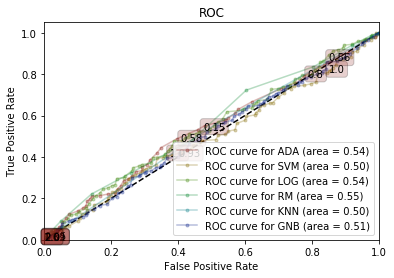

In [256]:
X_train, y_train, X_test, y_test=mask(DataR,DataR.columns[:-3],'Target1', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

For the Close data we are getting slightly better results. Lets try the same thing for Open data and using features as before

# Label 2: Open

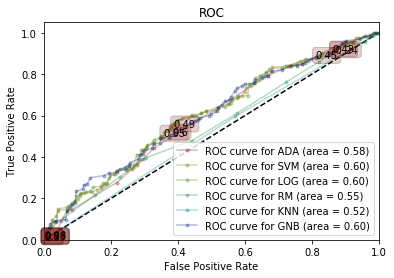

In [209]:
X_train, y_train, X_test, y_test=mask(DataTemp,Features_label2,'Target2', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

# Label 3: Returns

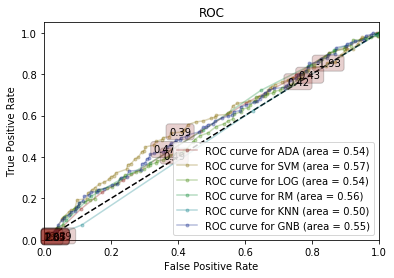

In [210]:
X_train, y_train, X_test, y_test=mask(DataTemp,DataTemp.columns[:-3],'Target3', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

In [214]:
HSI_MA10 = MA(HSI["HSI_Close"],10)
AXJO_MA10 = MA(AXJO["AXJO_Close"],10)
SSE_MA10 = MA(SSE["SSE_Close"],10)

In [235]:
#df = pd.merge(df1, df2, left_index=True, right_index=True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
NewData = pd.merge(DataTemp[Features_label2],pd.DataFrame(HSI_MA10),left_index=True,right_index=True)
NewData = pd.merge(NewData,pd.DataFrame(AXJO_MA10),left_index=True,right_index=True)
NewData = pd.merge(NewData,pd.DataFrame(SSE_MA10),left_index=True,right_index=True)
NewData = pd.merge(NewData,pd.DataFrame(Label2),left_index=True,right_index=True)
NewData["MA_10_x"] = scaler.fit_transform(NewData["MA_10_x"].reshape(-1,1))
NewData["MA_10_y"] = scaler.fit_transform(NewData["MA_10_y"].reshape(-1,1))
NewData["MA_10"] = scaler.fit_transform(NewData["MA_10"].reshape(-1,1))

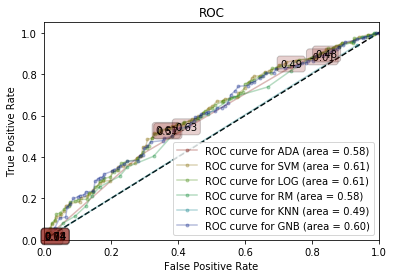

In [237]:
X_train, y_train, X_test, y_test=mask(NewData,NewData.columns[:-1],'Target2', predict)
ada=cv_optimize(X_train, y_train, X_test, y_test,10, 'ADA',{'n_estimators':[10,20,50],'learning_rate':[0.8,1.0,1.2]})
log=cv_optimize(X_train, y_train, X_test, y_test, 10, 'LOG', {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
svm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'SVM', {"C": [0.01, 0.1, 1.0, 10.0, 100.0]})
rm=cv_optimize(X_train, y_train, X_test, y_test, 10, 'RF', {"n_estimators": [10,20,50,100]})
knn=cv_optimize(X_train, y_train, X_test, y_test, 10, 'KNN', {"n_neighbors": [3,5,7,9,11,13]})
gnb=cv_optimize(X_train,y_train,X_test, y_test, 10,'GNB',[])
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("ADA",ada, y_test, X_test, labe=100, skip=3,proba=True)
    make_roc("SVM",svm, y_test, X_test, ax,labe=100, skip=3,proba=False)
    make_roc("LOG",log, y_test, X_test, ax,labe=100, skip=3,proba=True)
    make_roc("RM",rm,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("KNN",knn,y_test, X_test,ax,labe=100, skip=3,proba=True)
    make_roc("GNB",gnb,y_test, X_test,ax,labe=100, skip=3,proba=True)

By adding more features such as moving average of the other indices, the accuracy improved.

# Conclusion

Stock prediction is an active area of research and many hedge funds are already exploiting the ML algorithms. So to find any pattern is very difficult. Also, S&P500 index is the most common dataset for Machine Learning reseacrh. If there exists any profit making algo - people and institutions tend to use it until equilibrium is achieved and it can be no longer used. Even after that, I was able to achieve a **maximum accuracy** of **61%** for prediction of next day Open using **Support Vector Classifier**. Also the efficient market hypothesis states that it is impossible to beat the market because the current price reflects and incorporates all the relevant information and thus prediction is impossible.
According to the EMH, stock prices will only respond to new information and so will follow a
random walk. If they only respond to new information, they cannot be predicted. That the stocks
follow a random walk is actually a sign of market efficiency, since predictable movement would
mean that information was not being reflected by the market prices. There are three variants of this theory – weak, semi-strong, and strong. Most research has
concluded that the semi-strong version holds true. This version claims that stock prices reflect all
publicly available information, but private information can be used to unfairly predict profits. This
is the basis behind strong insider trading laws. Kalman filtering constantly adjust the prediction time series by including the new information. The fitted data has a trend fitting power of close to 90%.
High frequency trades can make use of this 61% accuracy for significant profits.

Bibiliography
1. Predicting Stock Price Direction using Support Vector Machines By Saahil Madge
2. Predicting Market Fluctuations via Machine Learning by Michael Lim,Yong Su
3. Forecasting S&P 500 Stock Index Using Statistical Learning Models by Chongda Liu, Jihua Wang, Di Xiao, Qi Liang
4. Predicting stock and stock price index movement using Trend Deterministic Data Preparation and machine learning techniques by Jigar Patel, Sahil Shah, Priyank Thakkar, K Kotecha